# Demonstrating p-value metric for peak extraction

Comparison on picked peak locations based on the z-score cutoff and the p-value metric.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from leopard_em.analysis import (
    extract_peaks_and_statistics_p_value,
    extract_peaks_and_statistics_zscore,
)
from leopard_em.analysis.match_template_peaks import match_template_peaks_to_dataframe
from leopard_em.analysis.pvalue_metric import probit_transform
from leopard_em.pydantic_models.results import MatchTemplateResult

## Load pre-existing data into a MatchTemplateResult object

In [ ]:
# Using pre-existing data from a previous match_template run
result_dir = "/data/papers/2025_Leopard-EM/xe30kv/results_match_tm_60S"
result_prefix = "xenon_219_000_0_output"
num_orientations = 1_600_000
num_defocus = 13

# Create the MathTemplateResult object
# This would normally be done automatically by the MatchTemplateManager after
# the program, but using this for demonstration purposes.
mt_result = MatchTemplateResult(
    allow_file_overwrite=True,
    mip_path=f"{result_dir}/{result_prefix}_mip.mrc",
    scaled_mip_path=f"{result_dir}/{result_prefix}_scaled_mip.mrc",
    correlation_average_path=f"{result_dir}/{result_prefix}_correlation_average.mrc",
    correlation_variance_path=f"{result_dir}/{result_prefix}_correlation_variance.mrc",
    orientation_psi_path=f"{result_dir}/{result_prefix}_orientation_psi.mrc",
    orientation_theta_path=f"{result_dir}/{result_prefix}_orientation_theta.mrc",
    orientation_phi_path=f"{result_dir}/{result_prefix}_orientation_phi.mrc",
    relative_defocus_path=f"{result_dir}/{result_prefix}_relative_defocus.mrc",
    total_projections=num_orientations * num_defocus,
    total_orientations=num_orientations,
    total_defocus=num_defocus,
)

# ensuring that files themselves are not overwritten
mt_result.allow_file_overwrite = False

In [3]:
mt_result.load_tensors_from_paths()

## Plotting probit transformed histogram of z-score and MIP

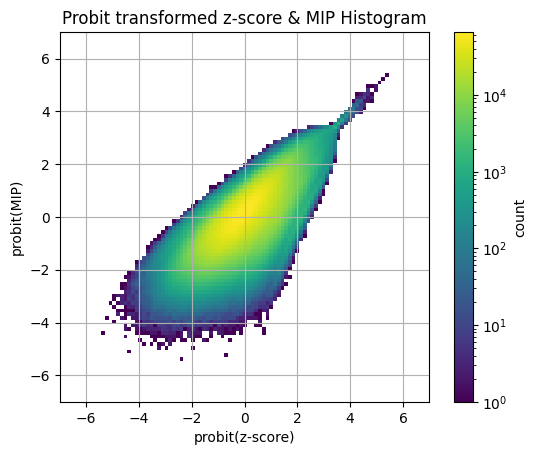

In [4]:
pro_zscorex = probit_transform(mt_result.scaled_mip.cpu().numpy().flatten())
pro_zscore = probit_transform(mt_result.mip.cpu().numpy().flatten())

x = np.linspace(-7, 7, 100)
y = np.linspace(-7, 7, 100)

hist = np.histogram2d(
    pro_zscorex,
    pro_zscore,
    bins=(x, y),
)

plt.imshow(
    hist[0],
    cmap="viridis",
    interpolation="nearest",
    norm=mpl.colors.LogNorm(),
    origin="lower",
    extent=(x[0], x[-1], y[0], y[-1]),
)
cbar = plt.colorbar()
cbar.set_label("count")
plt.title("Probit transformed z-score & MIP Histogram")
plt.xlabel("probit(z-score)")
plt.ylabel("probit(MIP)")
plt.grid()
plt.show()

In [5]:
peaks_zscore = extract_peaks_and_statistics_zscore(
    mip=mt_result.mip,
    scaled_mip=mt_result.scaled_mip,
    best_psi=mt_result.orientation_psi,
    best_theta=mt_result.orientation_theta,
    best_phi=mt_result.orientation_phi,
    best_defocus=mt_result.relative_defocus,
    correlation_average=mt_result.correlation_average,
    correlation_variance=mt_result.correlation_variance,
    total_correlation_positions=mt_result.total_projections,
)

df_zscore = match_template_peaks_to_dataframe(peaks_zscore)
df_zscore

,pos_y,pos_x,mip,scaled_mip,psi,theta,phi,relative_defocus,correlation_mean,correlation_variance,total_correlations
0,2729,66,16.941252,15.233522,123.0,112.5,86.616539,200.0,0.020207,1.110777,20800000
1,756,2677,13.567871,13.574046,168.0,92.5,17.500000,800.0,0.117597,0.990882,20800000
2,1331,250,13.711670,13.124782,69.0,107.5,241.751831,400.0,0.064889,1.039772,20800000
3,2672,211,14.027561,12.833559,94.5,90.0,177.500000,0.0,0.001663,1.092908,20800000
4,2013,2350,12.994080,12.787164,295.5,105.0,214.964035,-600.0,0.060302,1.011466,20800000
...,...,...,...,...,...,...,...,...,...,...,...
234,920,2623,8.293205,8.132643,294.0,62.5,11.250000,1200.0,0.059185,1.012465,20800000
235,1750,2817,8.251070,8.076269,259.5,125.0,210.508469,0.0,0.060906,1.014102,20800000
236,1157,2607,8.075300,7.979568,13.5,102.5,33.191490,0.0,0.020041,1.009486,20800000
237,1714,1431,7.837126,7.928540,42.0,152.5,218.181824,-800.0,0.066379,0.980098,20800000


In [6]:
peaks_p_value = extract_peaks_and_statistics_p_value(
    mip=mt_result.mip,
    scaled_mip=mt_result.scaled_mip,
    best_psi=mt_result.orientation_psi,
    best_theta=mt_result.orientation_theta,
    best_phi=mt_result.orientation_phi,
    best_defocus=mt_result.relative_defocus,
    correlation_average=mt_result.correlation_average,
    correlation_variance=mt_result.correlation_variance,
    total_correlation_positions=mt_result.total_projections,
    p_value_cutoff=0.0005,
)
df_p_value = match_template_peaks_to_dataframe(peaks_p_value)
df_p_value

,pos_y,pos_x,mip,scaled_mip,psi,theta,phi,relative_defocus,correlation_mean,correlation_variance,total_correlations
0,1173,2171,7.622286,7.556312,304.5,160.0,293.877563,200.0,0.006181,1.007913,20800000
1,1205,3440,7.626954,7.552557,178.5,30.0,80.000000,-200.0,0.031821,1.005637,20800000
2,1002,1529,7.636431,7.536526,316.5,17.5,242.790695,600.0,0.048741,1.006789,20800000
3,1436,2341,7.685410,7.437084,160.5,117.5,345.937500,1000.0,-0.002492,1.033725,20800000
4,1985,144,7.885936,7.119599,9.0,95.0,241.678314,1000.0,0.088111,1.095262,20800000
...,...,...,...,...,...,...,...,...,...,...,...
310,861,3492,8.542904,8.635539,126.0,85.0,143.496506,600.0,0.064959,0.981750,20800000
311,1190,3078,8.655206,8.813196,84.0,117.5,165.937500,800.0,0.059528,0.975319,20800000
312,1754,2812,8.814882,8.666915,262.5,127.5,214.736847,-200.0,0.042591,1.012158,20800000
313,3280,2411,8.994593,8.770643,3.0,150.0,265.000000,-1000.0,0.072189,1.017303,20800000


## Scatterplot of the two picked peak positions

Demonstrates that, generally speaking, the picked peak locations between the two methods are the same. Further analysis comparing the performance of the two metrics on *in situ* data is warranted.

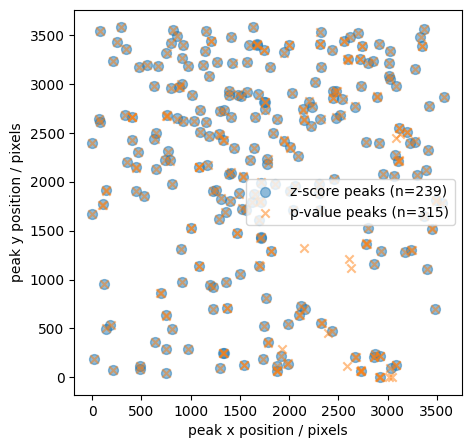

In [7]:
plt.figure(figsize=(5, 5))

# Scatterplot of the positions of the two methods
plt.scatter(
    df_zscore["pos_y"].values,
    df_zscore["pos_x"].values,
    label=f"z-score peaks (n={len(df_zscore)})",
    alpha=0.5,
    marker="o",
    s=50,
)
plt.scatter(
    df_p_value["pos_y"].values,
    df_p_value["pos_x"].values,
    label=f"p-value peaks (n={len(df_p_value)})",
    alpha=0.5,
    marker="x",
)
plt.xlabel("peak x position / pixels")
plt.ylabel("peak y position / pixels")
plt.legend()
plt.show()